In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt

from models.utr_net import motifNet
#from datasets.utr_dataset import BaseDataset

import os
import seaborn as sns
%matplotlib inline
import logomaker
import pandas as pd

ckpt_path = "ckpt/sinTrainer/utr_5.pth"
model = motifNet()
state = torch.load(ckpt_path) #, map_location='cpu')
model.load_state_dict(state)

<All keys matched successfully>

In [2]:
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

In [11]:
model = model.to('cpu')

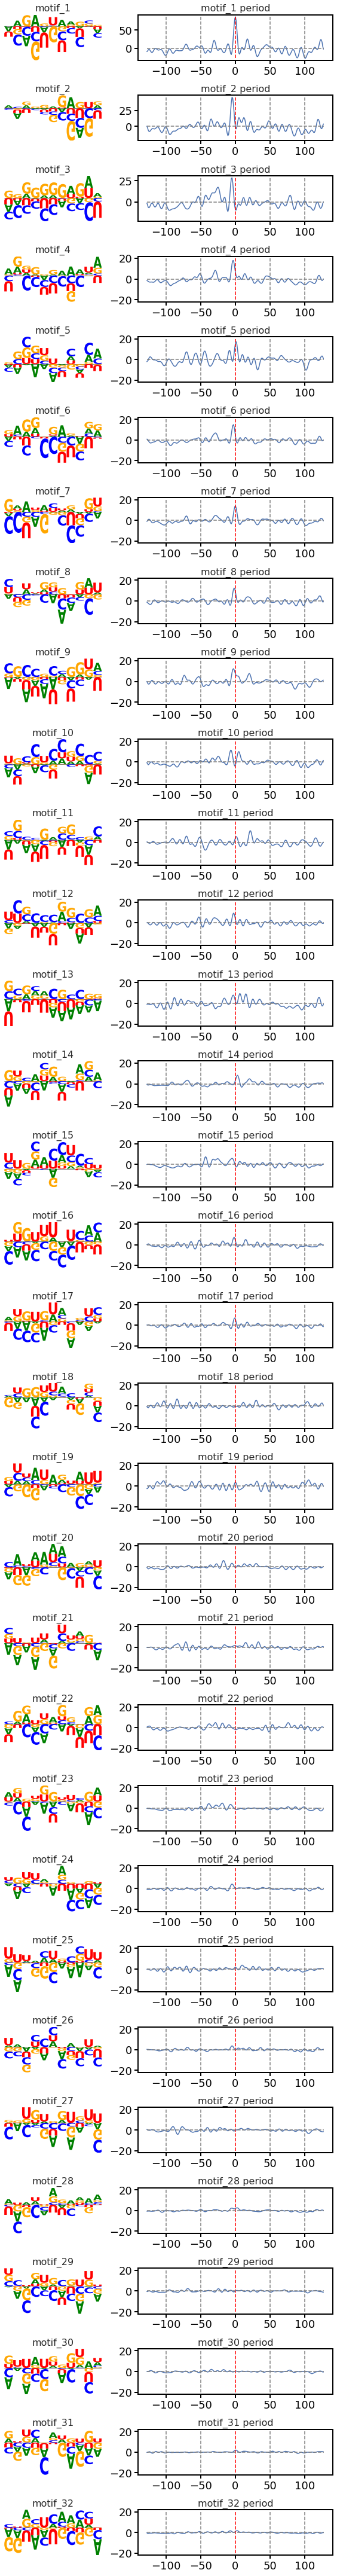

In [12]:
seq_len = 256
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model.conv_sin(coords)[0].detach().numpy()
kernel = model.layer1[0].weight.detach().numpy()

#rank kernel by positional activated signal
max_val = np.max(pos_feature, axis=1)
sort_idx = np.argsort(max_val)[::-1]

kernel = kernel[sort_idx]
pos_feature = pos_feature[sort_idx]

# fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(14,30))
fig, axes = plt.subplots(nrows=32, ncols=2, figsize=(8,60), gridspec_kw={'width_ratios': [0.5, 1]})

for i in range(32):
    nn_df = pd.DataFrame(kernel[i].transpose(), columns=list('ACGU'))
    ax = axes[i][0]
    ax.set_title('motif_%d' % (i+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)

    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([])

    ax = axes[i][1]
    v = pos_feature[i]
    ax.plot(np.arange(seq_len)-(seq_len//2), v)
    vmin = min(-20, min(v))
    vmax = max(20, max(v))
    
    ax.vlines(0, ymin=vmin, ymax=vmax, color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_title("motif_%d period" % (i+1),  fontdict={"size": 16})
    
    for n in range(-100, seq_len//2, 50):
        if abs(n) < 20:
            continue 
        ax.vlines(x=n, ymin=vmin, ymax=vmax, colors='grey', linestyles='--')

plt.tight_layout()

In [13]:
# Dictionary returning one-hot encoding of nucleotides.
nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}

def one_hot_encode(seq):    
    seq = seq.lower()
    a = np.array([nuc_d[x] for x in seq])
    return a

df = pd.read_csv("data/seq_256.csv")
neg_df = df[df.delta_psi==0].copy()
df = df[np.abs(df.delta_psi) > 0.2]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

In [16]:
neg_seq = np.random.choice(neg_df.seq.values, 1000, replace=False)

In [17]:
model = model.cuda()
model.eval()

feature_list = []
for i, line in df.iterrows():
    x = one_hot_encode(line.seq)
    x = torch.from_numpy(np.float32(x.transpose())).unsqueeze(0)
    
    feature = model.forward_with_feature(x.cuda())
#     feature = torch.cat([feature[:,:, :128-10], feature[:,:, 128+10:]], dim=2)
    feature_list.append(feature.detach().cpu().numpy().reshape(1, -1))
    
feature_arr = np.concatenate(feature_list, axis=0)
feature_arr.shape

(935, 8192)

In [18]:

feature_list = []
for seq in neg_seq:
    x = one_hot_encode(seq)
    x = torch.from_numpy(np.float32(x.transpose())).unsqueeze(0)
    
    feature = model.forward_with_feature(x.cuda())
#     feature = torch.cat([feature[:,:, :128-10], feature[:,:, 128+10:]], dim=2)
    feature_list.append(feature.detach().cpu().numpy().reshape(1, -1))
    
neg_feature_arr = np.concatenate(feature_list, axis=0)
neg_feature_arr.shape

(1000, 8192)

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca.fit(np.concatenate([feature_arr, neg_feature_arr], axis=0))

PCA(n_components=2, whiten=True)

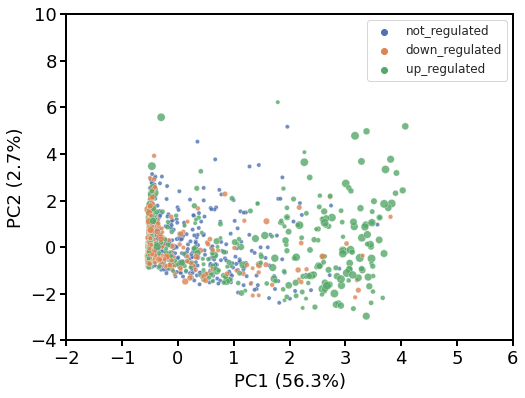

In [76]:
comp = pca.transform(feature_arr)

df.loc[:,'label'] = np.where(df.delta_psi>0.2, 1, 0).copy()
df.loc[:,'size'] = df.delta_psi.abs() 
df.loc[:, ["PC1", "PC2"]] = comp

neg_comp = pca.transform(neg_feature_arr)
neg_df = pd.DataFrame({
    'PC1': neg_comp[:, 0],
    'PC2': neg_comp[:, 1],
})

pos_df = df.loc[:, ['PC1', 'PC2', 'size']].copy()
pos_df.loc[:, 'glabel'] = df.label.apply(lambda x:'up_regulated' if x==1 else 'down_regulated')
pos_df.head()

neg_df.loc[:, 'size'] = 0.2
neg_df.loc[:, 'glabel'] = 'not_regulated'
plot_df = pd.concat([neg_df,pos_df], axis=0)
plot_df.head()


PC1_ratio, PC2_ratio = pca.explained_variance_ratio_[:2] * 100

fig = plt.figure(figsize=(8,6))
ax = fig.gca()

h_order = ['not_regulated', 'down_regulated', 'up_regulated']
sns.scatterplot(x='PC1', y='PC2', data=plot_df, size='size', hue='glabel', alpha=0.8, hue_order=h_order, ax=ax) 
ax.set_xlabel('PC1 (%.1f' % PC1_ratio + '%)', fontdict={"size": 18})
ax.set_ylabel('PC2 (%.1f' % PC2_ratio + '%)', fontdict={"size": 18})
ax.set_xlim(-2, 6)
ax.set_ylim(-4, 10)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:4], labels[1:4], loc='upper right', fontsize=12)

In [37]:
ax.legend?

In [20]:
df.head()

delta_psi                                                seq  label  \
15   3.508304  CTGTCCCGTGAGTACATCCAGGCCTTTTCGTTGCAGCATTCAATGC...      0   
20   3.182866  GTTCTATAAACCCCAGGCTTGGAATGATTCAGATTTTGGAGAATTT...      0   
21  10.000000  CGGGCCTCAGCCCGGTGGGAGGTGGGCAGCGAAGAGTGTACAGCGG...      0   
27   3.433198  GCCGCCTGGCTGTCCCACACGGCGGCACTGACAGGAGCCCTGCCCC...      0   
29   3.479403  CGCGAGGACGCCAGCGGGCGCTGTGCGTAGGAACCGCCGGGTGGCC...      0   

          size       PC1        PC2  
15   35.083036 -6.128254   6.958344  
20   31.828658  1.064521  -4.130480  
21  100.000000 -4.109727   2.950771  
27   34.331985 -5.022964  -1.934111  
29   34.794025 -4.249650  11.959005

In [21]:
comp[df.label==1].shape

(0, 2)

In [123]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5)
model.fit(comp[df.label==1])


KMeans(n_clusters=5)

In [141]:
CLUSTERS = 5
cmp = plt.cm.rainbow(np.linspace(0, 1, CLUSTERS))
cmp

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.96078431e-03, 7.09281308e-01, 9.23289106e-01, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [1.00000000e+00, 7.00543038e-01, 3.78411050e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [150]:
sub_df.head()

delta_psi structure                                                seq  \
27    0.200467         i  CGGGCCTCAGCCCGGTGGGAGGTGGGCAGCGAAGAGTGTACAGCGG...   
50    0.245363         i  AGCGACAAAGTGAAAGCCAGCCACTGGAGTCGCAGCCCGCCTCGGC...   
58    0.252790         i  AGCGACAAAGTGAAAGCCAGCCACTGGAGTCGCAGCCCGCCTCGGC...   
80    0.728161         i  AAAAACAGCTCGGGAATGCGAAGGCACCGGAGTCCAAAGTTGGCAG...   
119   0.610482         i  ATTAGCCTGGCGAGTTGGTGCATGCCTGTAATCCCAGCTACTCGGG...   

     label     size        PC1        PC2  group  
27       1  2.00467   7.767773  -4.013485      4  
50       1  2.45363  19.880001  13.881433      2  
58       1  2.52790  19.880001  13.881433      2  
80       1  7.28161 -21.026188  11.694140      3  
119      1  6.10482  47.513344   6.726374      0

In [158]:
sub_df.loc[:, "glabel"] = sub_df.group.apply(lambda x: 'group_%d' % x)

/tmp/ipykernel_645208/446831369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.loc[:, "glabel"] = sub_df.group.apply(lambda x: 'group_%d' % x)


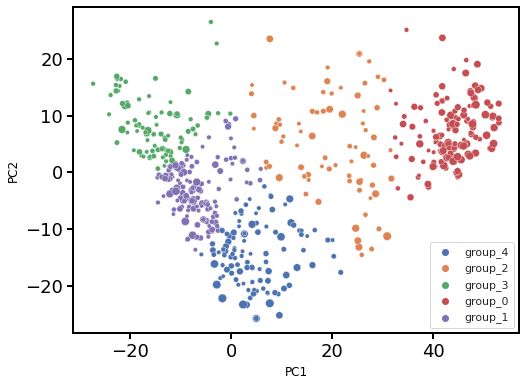

In [179]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
sns.scatterplot(x='PC1', y='PC2', data=sub_df, size='size', hue='glabel', ax=ax) 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:6], labels[1:6], loc='lower right')

In [175]:
labels

['glabel',
 'group_4',
 'group_2',
 'group_3',
 'group_0',
 'group_1',
 'size',
 '3.0',
 '4.5',
 '6.0',
 '7.5',
 '9.0']

In [160]:
?plt.legend

In [132]:
sub_df = df[df.label==1] 
sub_df.loc[:, "group"] = model.labels_

sub_df.head()

/tmp/ipykernel_645208/3975316849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.loc[:, "group"] = model.labels_


delta_psi structure                                                seq  \
27    0.200467         i  CGGGCCTCAGCCCGGTGGGAGGTGGGCAGCGAAGAGTGTACAGCGG...   
50    0.245363         i  AGCGACAAAGTGAAAGCCAGCCACTGGAGTCGCAGCCCGCCTCGGC...   
58    0.252790         i  AGCGACAAAGTGAAAGCCAGCCACTGGAGTCGCAGCCCGCCTCGGC...   
80    0.728161         i  AAAAACAGCTCGGGAATGCGAAGGCACCGGAGTCCAAAGTTGGCAG...   
119   0.610482         i  ATTAGCCTGGCGAGTTGGTGCATGCCTGTAATCCCAGCTACTCGGG...   

     label     size        PC1        PC2  group  
27       1  2.00467   7.767773  -4.013485      4  
50       1  2.45363  19.880001  13.881433      2  
58       1  2.52790  19.880001  13.881433      2  
80       1  7.28161 -21.026188  11.694140      3  
119      1  6.10482  47.513344   6.726374      0

In [133]:
sub_df.to_csv("data/kmeans_seq.csv", index=False)

In [135]:
len(sub_df.seq.values[0])

256

In [3]:
# kernel = model.layer_a[0].weight.detach().numpy()
# np.save("data/utr_kernel_mt_a.npy", kernel)

# kernel = model.layer1[0].weight.detach().numpy()
# np.save("data/utr_kernel_mt_1.npy", kernel)

# kernel = model_p.layer_a[0].weight.detach().numpy()
# np.save("data/utr_kernel_pnet_a.npy", kernel)

In [4]:
# kernel1 = model.layer1[0].weight.detach().numpy()
# kernel2 = model_p.layer_a[0].weight.detach().numpy()
# kernel3 = model_p.layer_a[0].weight.detach().numpy()

# cb_kernel = np.concatenate([kernel1, kernel2, kernel3], axis=0)
# cb_kernel.shape

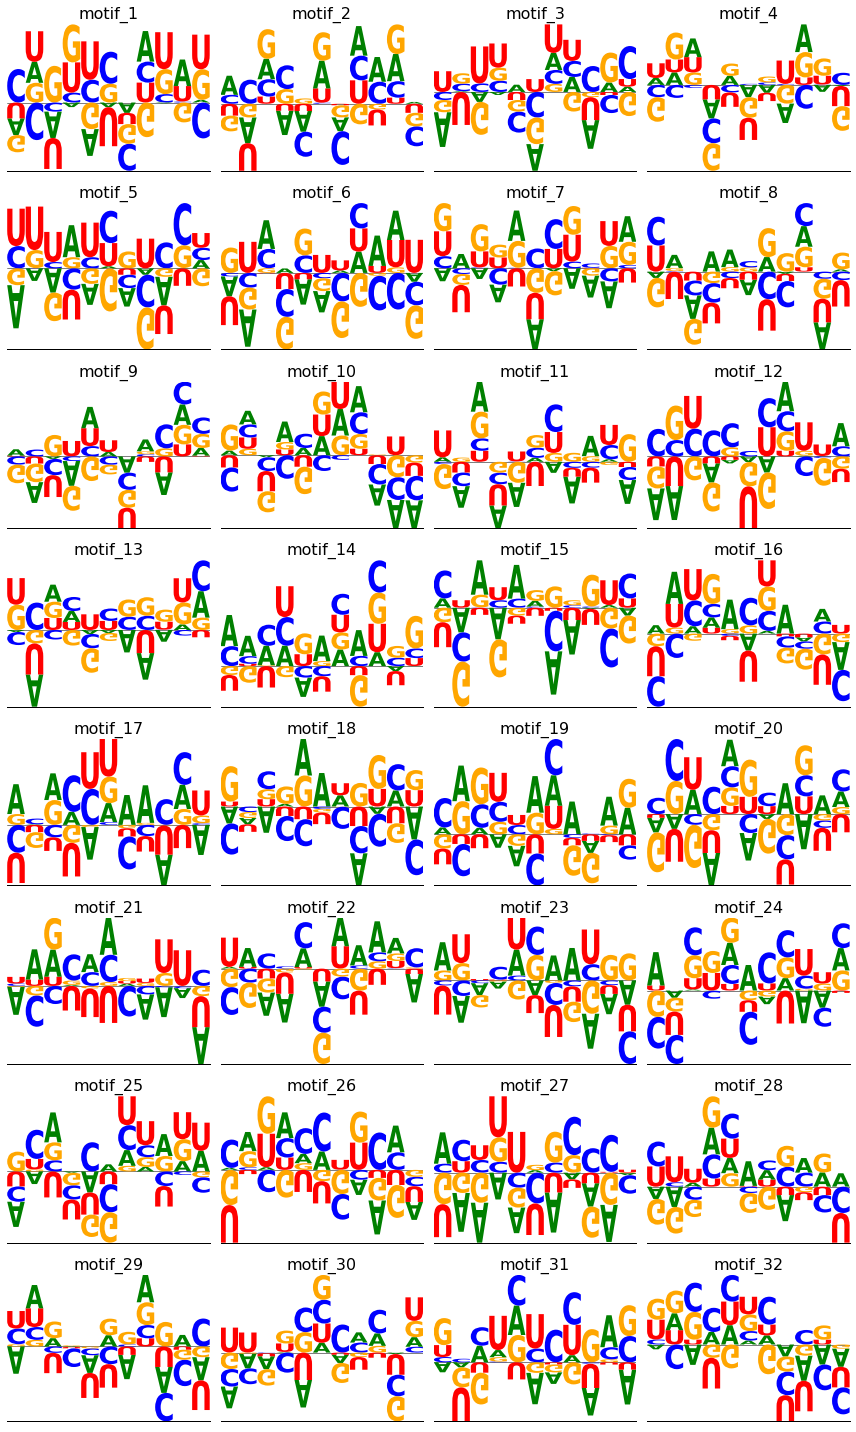

In [5]:
kernel = model.layer_a[0].weight.detach().numpy()

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(12,20))
with torch.no_grad():
    for i in range(32):
        nn_df = pd.DataFrame(kernel[i].transpose(), columns=list('ACGU'))
        ax = axes[i//4][i%4]
        ax.set_title('motif_%d' % (i+1), fontdict={"size": 16})
        nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
        nn_logo.style_spines(visible=False)
        nn_logo.style_spines(spines=['bottom'], visible=True)

        nn_logo.ax.set_xticks([])
        nn_logo.ax.set_yticks([])
plt.tight_layout()

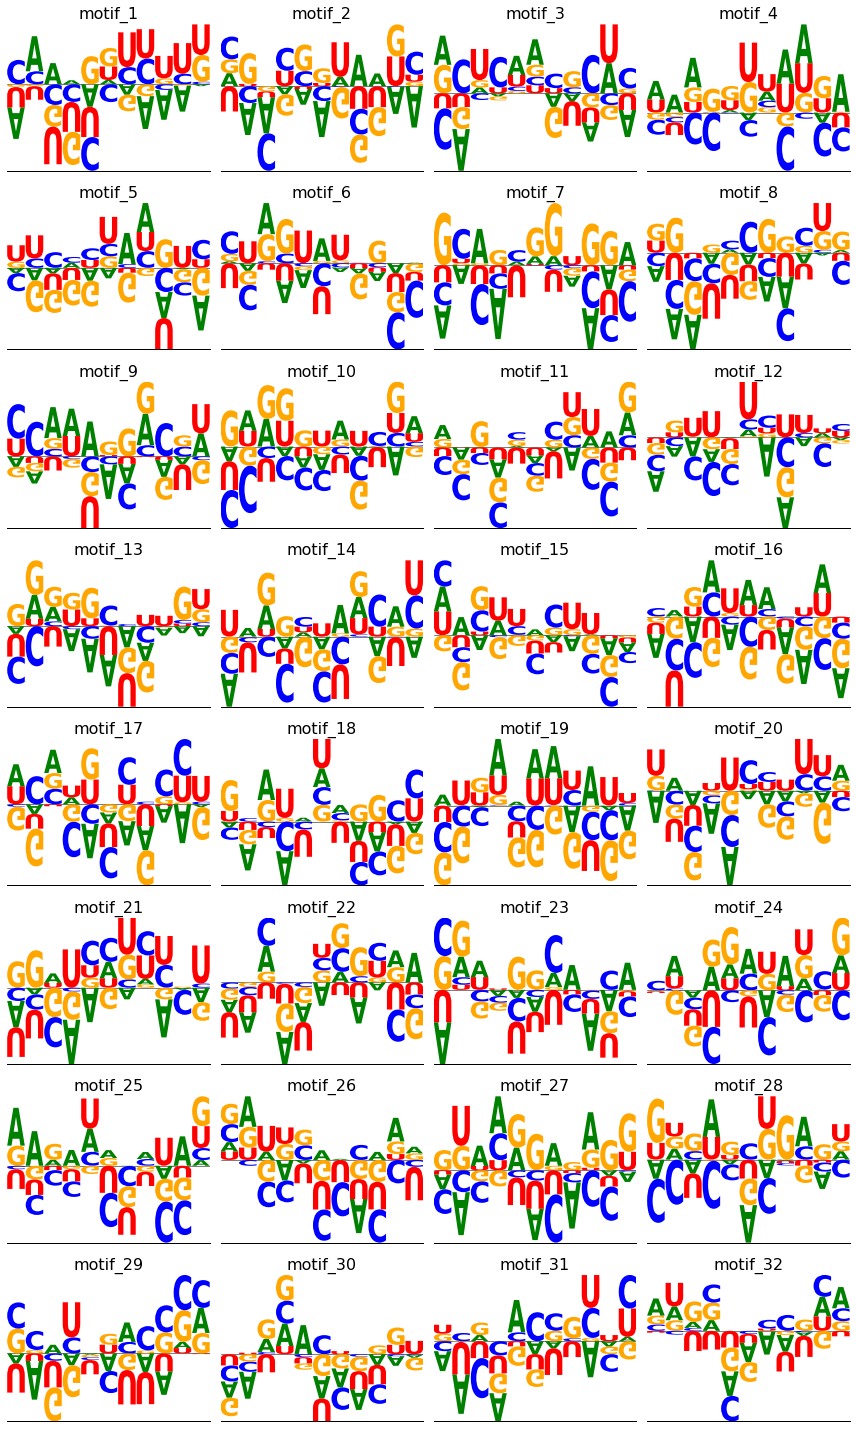

In [2]:
kernel = model.layer1[0].weight.detach().numpy()

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(12,20))
with torch.no_grad():
    for i in range(32):
        nn_df = pd.DataFrame(kernel[i].transpose(), columns=list('ACGU'))
        ax = axes[i//4][i%4]
        ax.set_title('motif_%d' % (i+1), fontdict={"size": 16})
        nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
        nn_logo.style_spines(visible=False)
        nn_logo.style_spines(spines=['bottom'], visible=True)

        nn_logo.ax.set_xticks([])
        nn_logo.ax.set_yticks([])
plt.tight_layout()

In [2]:
# fig, axes = plt.subplots(nrows=32, ncols=2, figsize=(12,50), gridspec_kw={'width_ratios': [0.6, 2]})
# with torch.no_grad():
#     for i in range(32):
#         nn_df = pd.DataFrame(kernel[i].transpose(), columns=list('ACGU'))
#         ax = axes[i][0]
#         ax.set_title('motif_%d' % (i+1), fontdict={"size": 16})
#         nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
#         nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

#         nn_logo.ax.set_xticks([])
#         nn_logo.ax.set_yticks([])

#         ax = axes[i][1]
#         xx = list(range(100))
#         ax.plot(xx, pos_feature[:, i])
#         ax.set_title("motif_%d period" % (i+1),  fontdict={"size": 16})

#         for n in range(21, 80, 3):
#             ax.vlines(x=n, ymin=-1, ymax=1, colors='grey', linestyles='--')

# plt.tight_layout()

In [3]:
# pos_feature= model.RNA_siren(coords).squeeze(0)
# pos_feature2= model.RNA_siren2(coords).squeeze(0)

In [5]:
model_p = PNet()

ckpt_path = "ckpt/sinTrainer/pnet-5.pth"
state = torch.load(ckpt_path, map_location='cpu')
model_p.load_state_dict(state)

<All keys matched successfully>

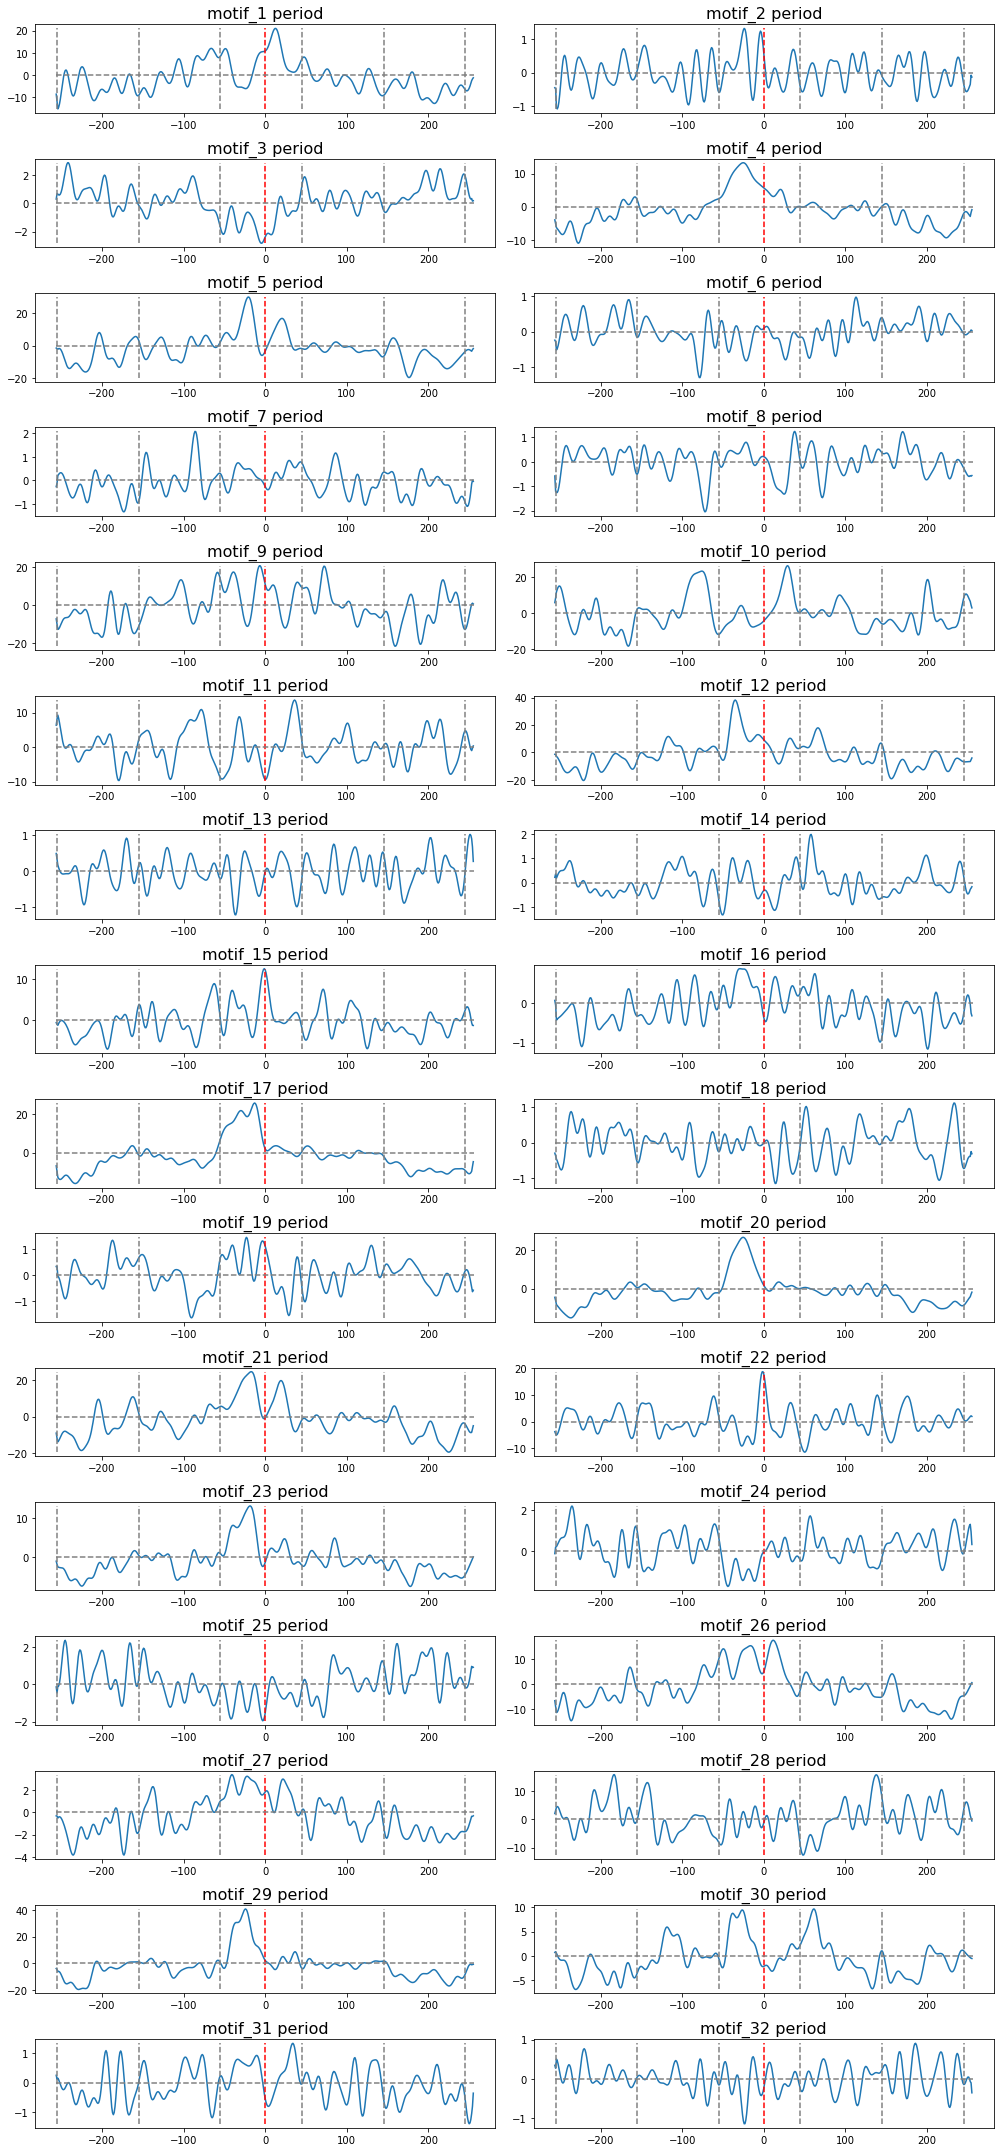

In [10]:
from numpy.fft import fft
seq_len = 512
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model.conv_sin(coords)[0].detach().numpy()

fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(14,30))

for i in range(32):
    ax = axes[i//2][i%2]
    v = pos_feature[i]
    ax.plot(np.arange(seq_len)-256, v)
    ax.vlines(0, ymin=min(v), ymax=max(v), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
#     ax.set_xlim(1000,2000)
    ax.set_title("motif_%d period" % (i+1),  fontdict={"size": 16})
    
    for n in range(-seq_len//2 + 1, seq_len//2, 100):
        if n == seq_len//2:
            continue
        ax.vlines(x=n, ymin=min(v), ymax=max(v), colors='grey', linestyles='--')

plt.tight_layout()

Text(296.7, 0.5, 'B motifs')

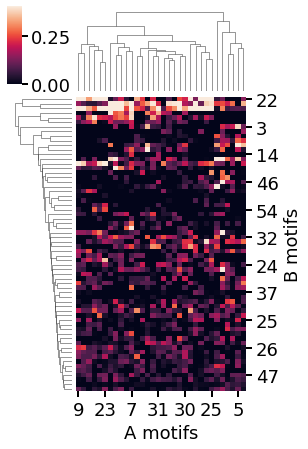

In [370]:
dense = model_p.layer_d[0].weight.detach().numpy()#[:,:,0]
dense = dense.reshape(32, 64)

# fig = plt.figure(figsize=(17,8))
# ax = plt.gca()
grid = sns.clustermap(dense.transpose(), robust=True, 
               figsize=(4, 6),
               dendrogram_ratio=(.26, .22),
#                mask=dense<0.5,
               vmin=0,
           )

# plt.tight_layout()
# plt.yticks(rotation=0)
grid.ax_heatmap.set_xlabel('A motifs', fontdict={'size': 18})
grid.ax_heatmap.set_ylabel('B motifs', fontdict={'size': 18})


In [371]:
grid.fig.savefig('graph/5utr_heatmap.pdf')

In [17]:
idx1 = np.where(dense[:,0] >0.15)[0]
idx1

array([ 1,  9, 14, 18, 19, 28])

In [72]:
idx2 = [0] * 6

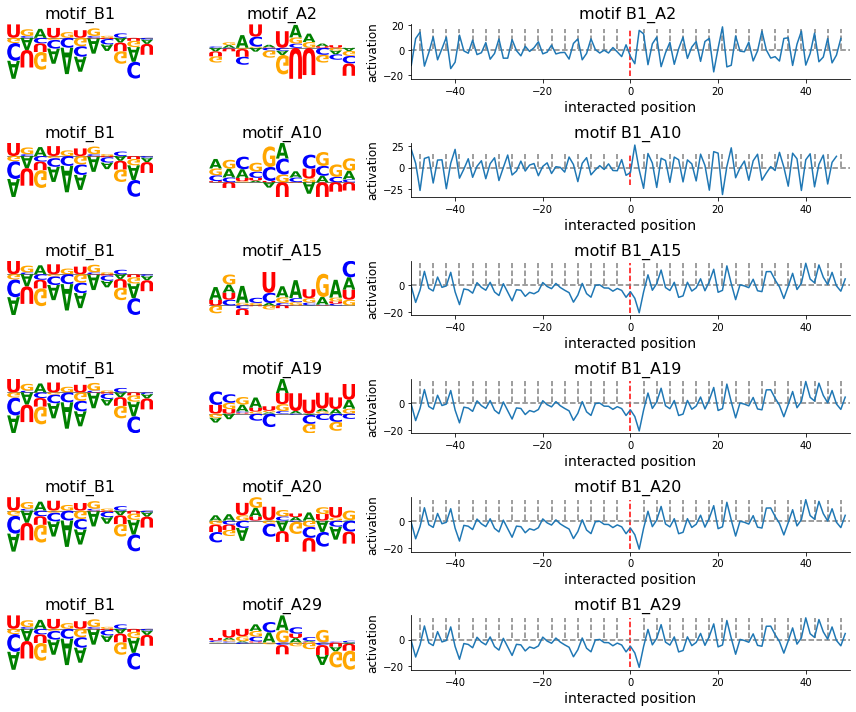

In [77]:
seq_len = 100
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model_p.conv_sin(coords)[0].detach().numpy()

kernel_A = model.layer1[0].weight.detach().numpy()
kernel_B = model_p.layer_a[0].weight.detach().numpy()

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,10), gridspec_kw={'width_ratios': [0.4, 0.4, 1.2]})
offset = 0

for i in range(6):
    ax = axes[i][1]
    nn_df = pd.DataFrame(kernel_A[idx1[i+offset]].transpose(), columns=list('ACGU'))
    ax.set_title('motif_A%d' % (idx1[i+offset]+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([])

    ax = axes[i][0]
    nn_df = pd.DataFrame(kernel_B[idx2[i+offset]//1].transpose(), columns=list('ACGU'))
    ax.set_title('motif_B%d' % (idx2[i+offset]//1+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([]) 

    ax = axes[i][2]
    pv = pos_feature[idx2[i+offset]]
    
    if i == 0:
        pv2 = pv[1:] - pv[:-1]
        ax.plot(np.arange(-seq_len//2, seq_len//2 -1), pv2)
    elif i == 1:
        pv2 = pv[1:] - pv[:-1]
        pv2 = pv2[1:] - pv2[:-1]
        ax.plot(np.arange(-seq_len//2, seq_len//2 -2), pv2)
    else:
        ax.plot(np.arange(-seq_len//2, seq_len//2), pv)
    
    ax.vlines(0, ymin=pv.min(), ymax=pv.max(), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_xlim(-seq_len//2, seq_len//2)
    ax.set_title("motif B%d_A%d " % (idx2[i+offset]//1+1, idx1[i+offset]+1),  fontdict={"size": 16})
    ax.set_ylabel("activation", fontdict={'size': 12})
    ax.set_xlabel("interacted position", fontdict={'size': 14})
    
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
    for n in range(-48, 50, 3):
        if n == 0:
            continue
        ax.vlines(x=n, ymin=1, ymax=pv.max(), colors='grey', linestyles='--')
    
    if i > 2:
        continue
    
plt.tight_layout()

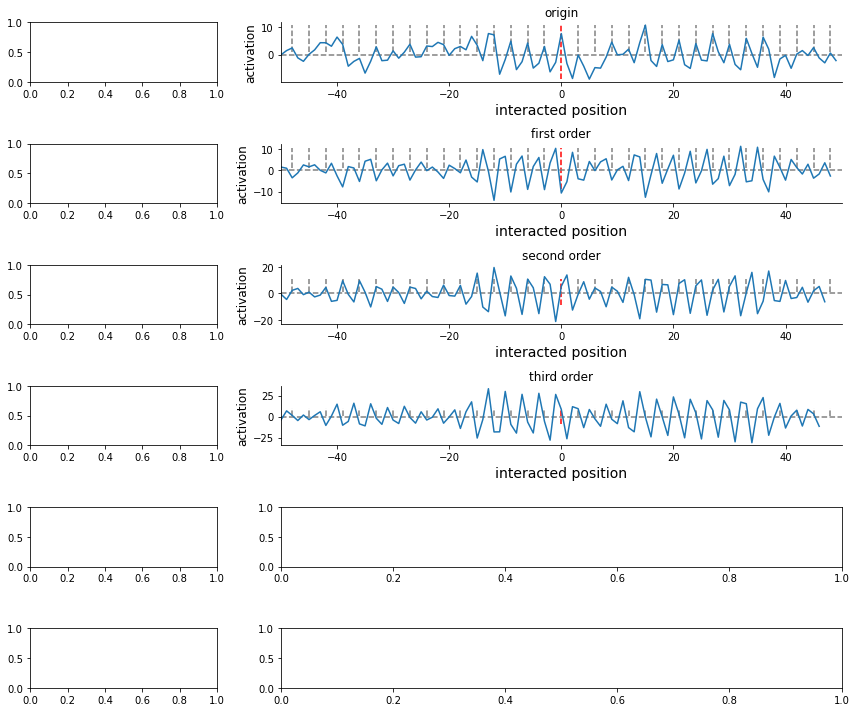

In [85]:
seq_len = 100
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model_p.conv_sin(coords)[0].detach().numpy()

kernel_A = model.layer1[0].weight.detach().numpy()
kernel_B = model_p.layer_a[0].weight.detach().numpy()

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12,10), gridspec_kw={'width_ratios': [0.4,  1.2]})
offset = 0

for i in range(4):
    ax = axes[i][1]
    pv = pos_feature[55]
    
    if i == 0:
        ax.plot(np.arange(-seq_len//2, seq_len//2), pv)
        ax.set_title("origin")
    elif i == 1:
        pv2 = pv[1:] - pv[:-1]
        ax.plot(np.arange(-seq_len//2, seq_len//2 -1), pv2)
        ax.set_title("first order")
    elif i == 2:
        pv2 = pv[1:] - pv[:-1]
        pv2 = pv2[1:] - pv2[:-1]
        ax.plot(np.arange(-seq_len//2, seq_len//2 -2), pv2)
        ax.set_title("second order")
    else:
        pv2 = pv[1:] - pv[:-1]
        pv2 = pv2[1:] - pv2[:-1]
        pv2 = pv2[1:] - pv2[:-1]
        ax.plot(np.arange(-seq_len//2, seq_len//2 -3), pv2)
        ax.set_title("third order")
        
    
    ax.vlines(0, ymin=pv.min(), ymax=pv.max(), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_xlim(-seq_len//2, seq_len//2)
    
    ax.set_ylabel("activation", fontdict={'size': 12})
    ax.set_xlabel("interacted position", fontdict={'size': 14})
    
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
    for n in range(-48, 50, 3):
        if n == 0:
            continue
        ax.vlines(x=n, ymin=1, ymax=pv.max(), colors='grey', linestyles='--')

    
plt.tight_layout()

In [21]:
fig.savefig('graph/5utr_period_B1.pdf')

(32, 4, 11)

In [373]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [375]:
kernel_A.shape

(32, 4, 11)

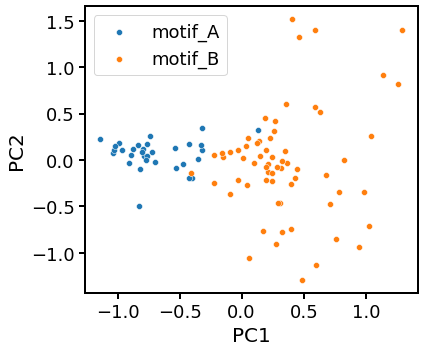

In [394]:
# feat_A = np.argmax(kernel_A, axis=1)
# feat_B = np.argmax(kernel_B, axis=1)
feat_A = kernel_A.reshape((32, 4*11))
feat_B = kernel_B.reshape((64, 4*11))
feat_C = np.concatenate([feat_A, feat_B], axis=0)

pca.fit(feat_C)
comp_A = pca.transform(feat_A)
comp_B = pca.transform(feat_B)

A_df = pd.DataFrame({
            'PC1': comp_A[:, 0],
            'PC2': comp_A[:, 1],
            }
        )

B_df = pd.DataFrame({
            'PC1': comp_B[:, 0],
            'PC2': comp_B[:, 1],
            }
        )


fig = plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', s=36, data=A_df, label='motif_A')
sns.scatterplot(x='PC1', y='PC2', s=36, data=B_df, label='motif_B')
plt.xlabel("PC1", fontdict={'size':20})
plt.ylabel("PC2", fontdict={'size':20})
plt.legend(loc='upper left', fontsize=18)
plt.tight_layout()

In [395]:
fig.savefig('graph/5utr_PCA.pdf')

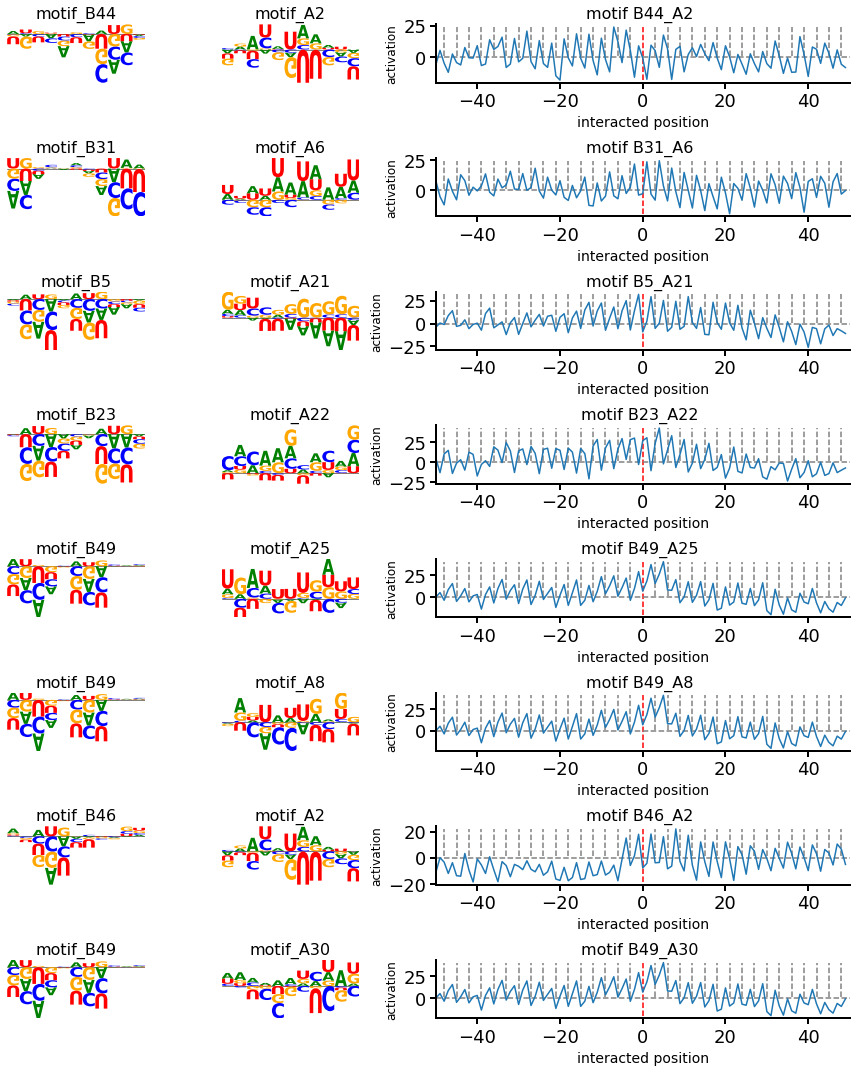

In [412]:
seq_len = 100
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model_p.conv_sin(coords)[0].detach().numpy()

kernel_A = model.layer1[0].weight.detach().numpy()
kernel_B = model_p.layer_a[0].weight.detach().numpy()

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(12,15), gridspec_kw={'width_ratios': [0.4, 0.4, 1.2]})
offset = 0

for i in range(8):
    ax = axes[i][1]
    nn_df = pd.DataFrame(kernel_A[idx1[i+offset]].transpose(), columns=list('ACGU'))
    ax.set_title('motif_A%d' % (idx1[i+offset]+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([])

    ax = axes[i][0]
    nn_df = pd.DataFrame(kernel_B[idx2[i+offset]//1].transpose(), columns=list('ACGU'))
    ax.set_title('motif_B%d' % (idx2[i+offset]//1+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([]) 

    ax = axes[i][2]
    pv = pos_feature[idx2[i+offset]]
    ax.plot(np.arange(-seq_len//2, seq_len//2), pv)
    
    ax.vlines(0, ymin=pv.min(), ymax=pv.max(), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_xlim(-seq_len//2, seq_len//2)
    ax.set_title("motif B%d_A%d " % (idx2[i+offset]//1+1, idx1[i+offset]+1),  fontdict={"size": 16})
    ax.set_ylabel("activation", fontdict={'size': 12})
    ax.set_xlabel("interacted position", fontdict={'size': 14})
    
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
    for n in range(-48, 50, 3):
        if n == 0:
            continue
        ax.vlines(x=n, ymin=1, ymax=pv.max(), colors ='grey', linestyles='--')
    
plt.tight_layout()

In [411]:
idx1, idx2 = np.where(dense>0.4)
ai = np.random.choice(list(range(len(idx1))), 8, replace=False)
idx1 = idx1[ai]
idx2 = idx2[ai]

idx1.shape

(8,)

In [413]:
fig.savefig('graph/UTR5_supp_interaction.pdf')

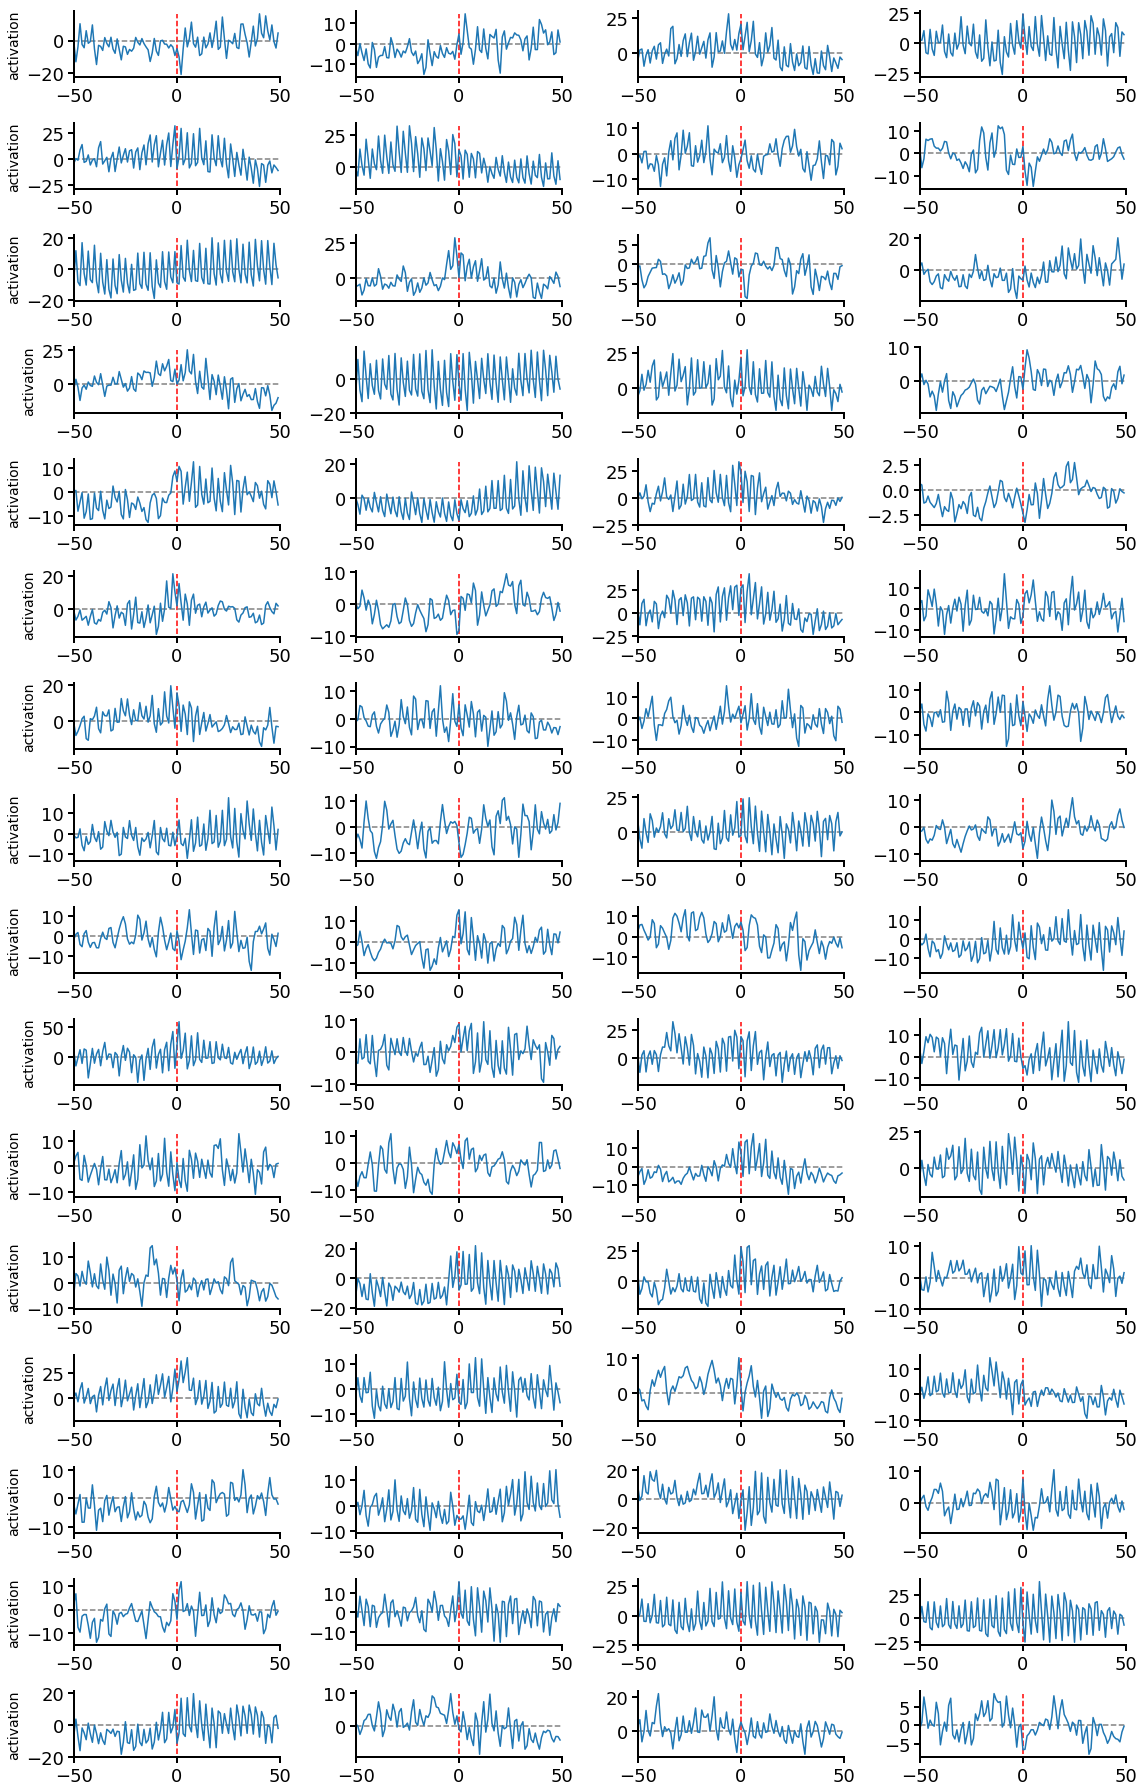

In [417]:
fig, axes = plt.subplots(nrows=16, ncols=4, figsize=(16,25))

for i in range(64):
    ax = axes[i//4][i%4]
    pv = pos_feature[i]
    ax.plot(np.arange(-seq_len//2, seq_len//2), pv)
    
    ax.vlines(0, ymin=pv.min(), ymax=pv.max(), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_xlim(-seq_len//2, seq_len//2)
#     ax.set_title("position_weight_%d " % (i+1),  fontdict={"size": 16})
    if i % 4 == 0:
        ax.set_ylabel("activation", fontdict={'size': 14})
#     ax.set_xlabel("interacted coordinate", fontdict={'size': 14})
    
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
#     for n in range(-48, 50, 3):
#         if n == 0:
#             continue
#         ax.vlines(x=n, ymin=1, ymax=pv.max(), colors ='grey', linestyles='--')
    
plt.tight_layout()

In [418]:
fig.savefig('graph/UTR5_supp_position.pdf')

In [323]:
pos_feature.shape

(64, 100)

In [335]:
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

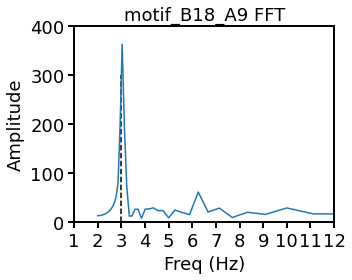

In [360]:
from numpy.fft import fft

seq_len = 100
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model_p.conv_sin(coords)[0].detach().numpy()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4)) #, gridspec_kw={'width_ratios': [0.4, 0.4, 1.2]})


ax = axes     
X = fft(pos_feature[17])
N = len(X)//2
xx = len(pos_feature[17])/(np.arange(N)+1)
ax.plot(xx, np.abs(X[1:N+1]))
ax.set_xlim(1,12)
ax.set_ylim(0,400)
ax.set_xticks(np.arange(12)+1)
ax.set_xlabel('Freq (Hz)',  fontdict={"size": 18})
ax.set_ylabel('Amplitude',  fontdict={"size": 18})
ax.vlines(3, ymin=0, ymax=300, colors ='black', linestyles='--')
ax.set_title("motif_B18_A9 FFT",  fontdict={"size": 18})


plt.tight_layout()

In [361]:
fig.savefig('graph/UTR5_fft.pdf')

In [22]:
df = pd.read_csv("data/prostate_motif_l21_br.csv")
df.head()

Mutant                           trans_wt  \
0  ALDH1B1_A_T_chr9_38392661_38395745  ALDH1B1_WT_chr9_38392661_38395745   
1    TAF1L_C_T_chr9_32635578_32635667    TAF1L_WT_chr9_32635578_32635667   
2  ALDH1B1_G_C_chr9_38392661_38395745  ALDH1B1_WT_chr9_38392661_38395745   
3   ATM_T_C_chr11_108093559_108098351   ATM_WT_chr11_108093559_108098351   
4   ZIC1_T_C_chr3_147127181_147127899   ZIC1_WT_chr3_147127181_147127899   

   trans_p_val  trans_LFC  trans_padj_fdr                              TE_wt  \
0          0.0     -0.766             0.0  ALDH1B1_WT_chr9_38392661_38395745   
1          0.0     -0.325             0.0    TAF1L_WT_chr9_32635578_32635667   
2          0.0     -0.492             0.0  ALDH1B1_WT_chr9_38392661_38395745   
3          0.0     -0.503             0.0   ATM_WT_chr11_108093559_108098351   
4          0.0      0.433             0.0   ZIC1_WT_chr3_147127181_147127899   

   TE_p_val  TE_LFC  TE_padj_fdr  5' UTR length (bp) Gene name  \
0     0.000  -0.378        0.000               153.0   ALDH1B1   
1     0.041  -0.018        0.405                90.0     TAF1L   
2     0.000  -0.305        0.000               153.0   ALDH1B1   
3     0.001   0.135        0.020               385.0       ATM   
4     0.991   0.020        0.996               704.0      ZIC1   

        5' UTR genomic coordinate  mut_pos mut_nt wt_nt  predict_rl_change  \
0  ALDH1B1_chr9_38392732_A_T_UTR5       72      T     A             -0.175   
1    TAF1L_chr9_32635663_C_T_UTR5        5      A     G             -0.004   
2  ALDH1B1_chr9_38392729_G_C_UTR5       69      C     G              0.007   
3    ATM_chr11_108093653_T_C_UTR5       95      C     T              0.017   
4    ZIC1_chr3_147127745_T_C_UTR5      559      C     T             -0.055   

   pos_to_start               wt_motif              mut_motif  \
0          81.0  CTGGGCGGCCATGTGGACAGA  CTGGGCGGCCTTGTGGACAGA   
1          85.0        CCCCGCCTTTATTCA        CCCCACCTTTATTCA   
2          84.0  GCCCTGGGCGGCCATGTGGAC  GCCCTGGGCGCCCATGTGGAC   
3         290.0  GCCGAATGTTTTGGGGCAGTG  GCCGAATGTTCTGGGGCAGTG   
4         145.0  GCCTGCAGGCTAGGACTTCGC  GCCTGCAGGCCAGGACTTCGC   

                                               wt_br  
0  ATTGGCCGCTGAGCCCCGGGCTGCGCGGAGGCGGGACCTGCGGCCA...  
1  CCCCGCCTTTATTCAGCTTCCGGTAGACGCTGGTAGGGTAAGGGAG...  
2  CTCATTGGCCGCTGAGCCCCGGGCTGCGCGGAGGCGGGACCTGCGG...  
3  AAGTCGCTGGCCATTGGTGGACATGGCGCAGGCGCGTTTGCTCCGA...  
4  CGGCTACTTTGCGTTTGGCCCGGCCAGCGCCCGGGCGCGCCGCGCC...

In [29]:
nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}

def onehot_encode(seq):
    seq = seq.lower()
    enc = np.array([nuc_d[x] for x in seq], dtype=np.float32)    
    return enc

In [45]:
seq_len = 100
coords = torch.linspace(-1, 1, steps=seq_len).view(1, 1, seq_len)
pos_feature = model_p.conv_sin(coords)[0].detach() #.numpy()
pos_feature.shape

torch.Size([64, 100])

In [75]:
kernel_A = model.layer1[0].weight.detach().numpy()
kernel_B = model_p.layer_a[0].weight.detach().numpy()
print(kernel_A.shape, kernel_B.shape)

(32, 4, 11) (64, 4, 11)


In [138]:
dense.shape

(32, 64)

In [188]:
dist_dict = {}
LFC_dict = {}

In [317]:

def pattern_match(m1, m2, p1, LFC, mut_pos, interval=0):
    # m1.shape     64, 11
    # p1.shape     32, 120
    # Wi shape     32, 64
#     delta_m = torch.abs(m1 - m2)
#     delta_m = m2 - m1
#     i1 = torch.argmin(delta_m, dim=1)
#     idx_list = i1.detach().cpu().numpy()#.tolist()

    for n in range(len(m1)):
        idx1 = torch.argmax(m1[n])
        idx2 = torch.argmax(m2[n])
        if m1[n, idx1] > m2[n, idx2]:
            idx = idx1
        else:
            idx = idx2
        
#         mt_global_idx = mut_pos + idx
#         if mt_global_idx % 3 != interval:
#             continue
        
        if not (m1[n, idx] < 0.1 and m2[n, idx] - m1[n, idx]> 0.4):  # wt motif create
            continue
        
        act_idx = np.where(dense[:, n]>0.1)[0]
        
        
        if len(act_idx) == 0:
            continue
            
        br = p1[act_idx, idx+10:idx+10+100]
        
#         print(act_idx, pos_feature.shape, br.shape)
        if br.shape[1] != 100:
            continue
#         pmat = pos_feature[act_idx] * br
#         pmat = pmat.detach().cpu().numpy()
#         pmat = [x for x in pmat if x.max() > 3]
        pmat = br
        
        if len(pmat) == 0:
            continue
        
        nr = len(pmat)
        for i in range(nr):
            key = '%d_%d' % (act_idx[i], n)
            
            if n not in [5, 14]:
                continue
            
            A_idx = np.where(pmat[i]> 1.)[0]
            if len(A_idx) == 0:
                continue
                
            B_idx = 51 + idx
            dist = B_idx - A_idx
            if key not in dist_dict.keys():
                dist_dict[key] = []
                LFC_dict[key] = []
            dist_dict[key] += dist.tolist()
            LFC_dict[key] += [LFC] * len(dist)

    

In [318]:

dist_dict = {}
LFC_dict = {}

for i in range(len(df)):
    line = df.iloc[i]
    
#     if line.mut_pos > 200:
#         continue
    
    if np.abs(line.TE_LFC) < 0.1:
        continue
    
    enc = onehot_encode(line.wt_motif)
    x = torch.from_numpy(enc.transpose()).unsqueeze(0)
    act_m1 = model_p.layer_a(x)[:,:,5:-5]
    
    enc = onehot_encode(line.mut_motif)
    x = torch.from_numpy(enc.transpose()).unsqueeze(0)
    act_m2 = model_p.layer_a(x)[:,:,5:-5]
    
    enc = onehot_encode(line.wt_br)
    x = torch.from_numpy(enc.transpose()).unsqueeze(0)
    act_p1 = model.layer1(x)

    pattern_match(act_m1[0], act_m2[0], act_p1[0], line.TE_LFC, line.mut_pos, interval=0)

In [319]:
len(dist_dict)

4

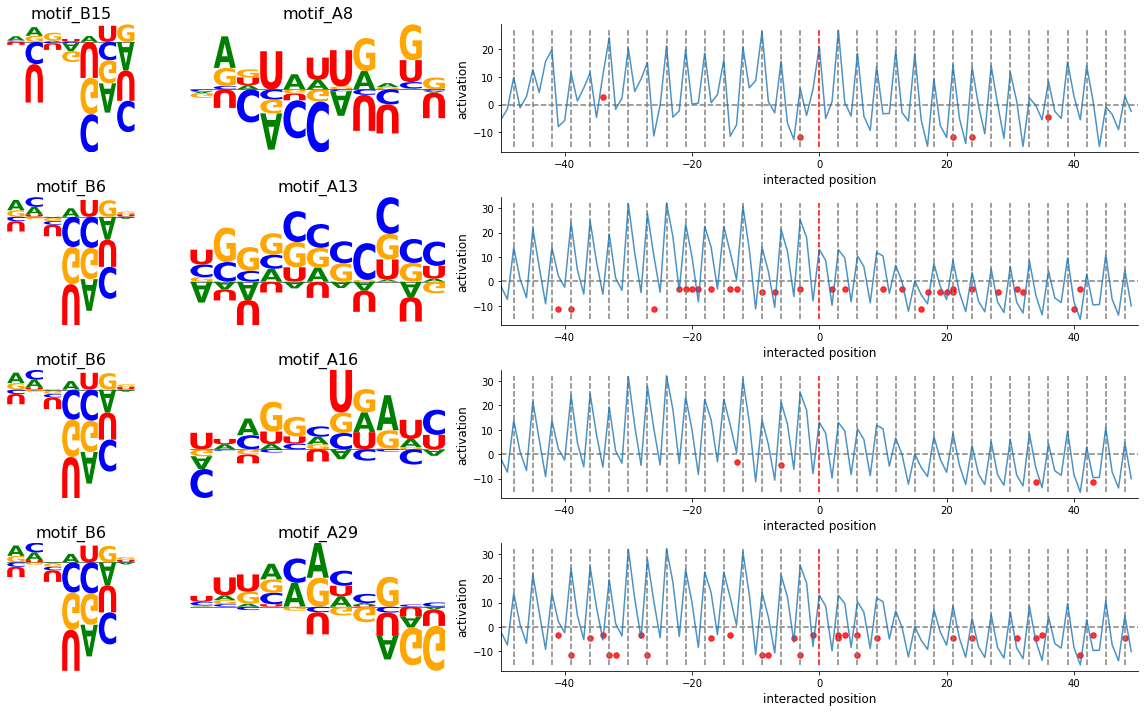

In [320]:
seq_len = 100
item_nums = len(dist_dict)
fig, axes = plt.subplots(nrows=item_nums, ncols=3, figsize=(16, item_nums*2.5), 
                         gridspec_kw={'width_ratios': [0.2, 0.4, 1.]})

# axes = [axes]
for n_row, (k,v) in enumerate(dist_dict.items()):
#     plt.figure(figsize=(12, 2))
    k_split = k.split('_')
    A_idx = int(k_split[0])
    B_idx = int(k_split[1])
    
    kA, kB = kernel_A[A_idx].transpose(), kernel_B[B_idx].transpose()

    ax = axes[n_row][1]
    nn_df = pd.DataFrame(kA, columns=list('ACGU'))
    ax.set_title('motif_A%d' % (A_idx+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([])

    ax = axes[n_row][0]
    nn_df = pd.DataFrame(kB[4:], columns=list('ACGU'))
    ax.set_title('motif_B%d' % (B_idx+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([]) 
    
    
    pv = pos_feature[B_idx]
    ax = axes[n_row][2]
    
    
    ax.plot(np.arange(-seq_len//2, seq_len//2), pv, alpha=0.8)
    
#     x = (np.random.random(len(v))*10 + 25) * np.array(LFC_dict[k])
    x = 25 * np.array(LFC_dict[k])
    ax.scatter(np.array(v), x, s=30, alpha=0.8, c='red')
#     ax.plot(np.arange(-seq_len//2, seq_len//2), pv0)
    

    ax.vlines(0, ymin=pv.min(), ymax=pv.max(), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_xlim(-seq_len//2, seq_len//2)
#         ax.set_title("motif B%d_A%d " % (n+1, act_idx[i]+1),  fontdict={"size": 16})
    ax.set_ylabel("activation", fontdict={'size': 12})
    ax.set_xlabel("interacted position", fontdict={'size': 12})

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    for _i in range(-48, 50, 3):
        if _i == 0:
            continue
        ax.vlines(x=_i, ymin=pv.min(), ymax=pv.max(), colors ='grey', linestyles='--')
        
plt.tight_layout()

In [321]:
fig.savefig('graph/5utr_variants_in_prostate_cancer.pdf')

In [ ]:
item_nums = len(dist_dict)

fig, axes = plt.subplots(nrows=item_nums, ncols=3, figsize=(13, item_nums*1.2), 
                         gridspec_kw={'width_ratios': [0.4, 0.4, 1.]})
    
for qi, data_list in enumerate(total_data):    
    kA, kB, pv, pv0 = data_list
    ax = axes[qi][1]
    nn_df = pd.DataFrame(kA, columns=list('ACGU'))
#         ax.set_title('motif_A%d' % (n+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([])

    ax = axes[qi][0]
    nn_df = pd.DataFrame(kB, columns=list('ACGU'))
#         ax.set_title('motif_B%d' % (act_idx[i]+1), fontdict={"size": 16})
    nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
    nn_logo.style_spines(visible=False)
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_yticks([]) 

    ax = axes[qi][2]
#             pv = pos_feature[act_idx[i]]
#         pv = pmat[i]

    ax.plot(np.arange(-seq_len//2, seq_len//2), pv0)
    ax.plot(np.arange(-seq_len//2, seq_len//2), pv)

    ax.vlines(0, ymin=pv.min(), ymax=pv.max(), color='red',  linestyles='dashed')
    ax.hlines(0, xmin=-seq_len//2, xmax=seq_len//2, color='grey',  linestyles='dashed')
    ax.set_xlim(-seq_len//2, seq_len//2)
#         ax.set_title("motif B%d_A%d " % (n+1, act_idx[i]+1),  fontdict={"size": 16})
    ax.set_ylabel("activation", fontdict={'size': 12})
    ax.set_xlabel("interacted position", fontdict={'size': 14})

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    for _i in range(-48, 50, 3):
        if _i == 0:
            continue
        ax.vlines(x=_i, ymin=1, ymax=pv.max(), colors ='grey', linestyles='--')

plt.tight_layout()

In [32]:
idx1, idx2 = np.where(dense>0.2)
len(idx1)

196

In [54]:
fig.savefig('graph/5utr_period.pdf')

In [3]:
# from numpy.fft import fft, ifft

# fig, axes = plt.subplots(nrows=16, ncols=4, figsize=(16,32), gridspec_kw={'width_ratios': [0.3, 0.3, 0.4, 0.6]})

# sr = 10
# m1 = model.mapping1[0].weight.detach().numpy()
# idx1 = np.argmax(m1, 1) 
# m2 = model.mapping2[0].weight.detach().numpy()
# idx2 = np.argmax(m2, 1) 

# with torch.no_grad():
#     for i in range(16):
#         ax = axes[i][0]
#         nn_df = pd.DataFrame(kernel[idx1[i]].transpose(), columns=list('ACGU'))
#         ax.set_title('motif_%d' % (idx1[i]+1), fontdict={"size": 16})
#         nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
#         nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

#         nn_logo.ax.set_xticks([])
#         nn_logo.ax.set_yticks([])

#         ax = axes[i][1]
#         nn_df = pd.DataFrame(kernel[idx2[i]].transpose(), columns=list('ACGU'))
#         ax.set_title('motif_%d' % (idx2[i]+1), fontdict={"size": 16})
#         nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
#         nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['bottom'], visible=True)

#         nn_logo.ax.set_xticks([])
#         nn_logo.ax.set_yticks([])
        
        
#         ax = axes[i][2]       
#         X = fft(pos_feature[26:76, i])
#         N = len(X)/2
#         T = N/sr
#         n = np.arange(N)
#         freq = n/T 
#         ax.plot(freq, np.abs(X[int(N):]))
#         ax.set_xlabel('Freq (Hz)')
#         ax.set_ylabel('Amplitude')
        
# #         ax.set_xticks(list(range(N)))
#         ax.set_title("motif_%d FFT1" % (i+1),  fontdict={"size": 16})

#         for n in range(0, 9, 3):
#             ax.vlines(x=n, ymin=0, ymax=50, colors='grey', linestyles='--')
            
            
# #         ax = axes[i][2]
# #         X = fft(pos_feature2[26:76, i])
# #         ax.plot(freq, np.abs(X[int(N):]))
# #         ax.set_xlabel('Freq (Hz)')
# #         ax.set_ylabel('Amplitude')
# #         ax.set_title("motif_%d FFT2" % (i+1),  fontdict={"size": 16})
# #         for n in range(0, 9, 3):
# #             ax.vlines(x=n, ymin=0, ymax=50, colors='grey', linestyles='--')
            
#         ax = axes[i][3]
#         xx = list(range(50))
#         ax.plot(xx, pos_feature[25:75, i])
#         ax.set_title("motif_%d period" % (i+1),  fontdict={"size": 16})

#         for n in range(0, 50, 3):
#             ax.vlines(x=n, ymin=-2, ymax=2, colors='grey', linestyles='--')
            
            
# #         ax = axes[i][4]
# #         xx = list(range(50))
# #         ax.plot(xx, pos_feature2[25:75, i])
# #         ax.set_title("motif_%d period" % (i+1),  fontdict={"size": 16})

# #         for n in range(0, 50, 3):
# #             ax.vlines(x=n, ymin=-2, ymax=2, colors='grey', linestyles='--')

# plt.tight_layout()

In [3]:
m1 = model.mapping1[0].weight.detach().numpy()
np.argmax(m1, 1) + 1

array([ 7,  3,  7,  3,  3,  7,  3,  7,  7,  7,  3,  5, 13,  3,  7,  3,  3,
        7,  3,  7,  5, 16,  7,  7,  3,  7,  3,  3,  7,  3,  3,  3])

In [4]:
m2 = model.mapping2[0].weight.detach().numpy()
np.argmax(m2, 1) + 1

array([13,  7,  3, 11,  7,  3,  8,  3,  3,  3,  7,  3,  5,  7,  3,  5,  7,
        3,  7,  3,  3,  3,  3,  3,  7,  3,  7,  7,  3,  7,  7,  5])

In [11]:
fig.savefig("motif_period.jpg")

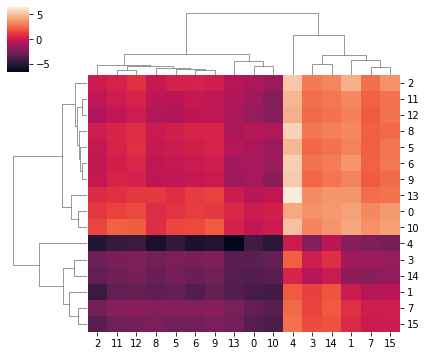

In [4]:
# dense = model.tMat.detach().numpy()
dense = model.fc[0].weight.detach().numpy()

dense = np.reshape(dense, [16, 16])


# plt.figure(figsize=(10,8))
sns.clustermap(dense, robust=False, 
               figsize=(6,5),
#             mask= np.abs(dense)<4,
#             annot=True, fmt='.1f',
           )

<AxesSubplot:>

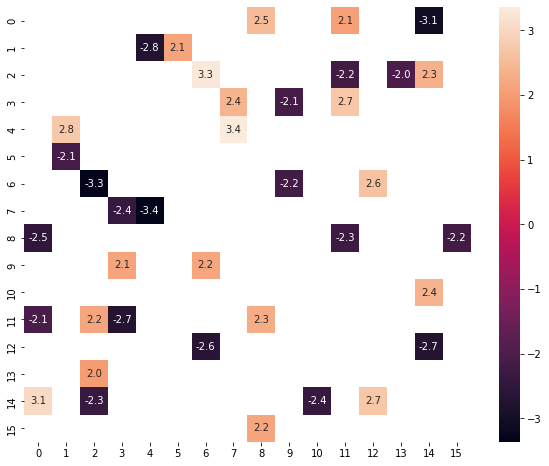

In [18]:
plt.figure(figsize=(10,8))
v = dense - dense.transpose()
sns.heatmap(v, 
            robust=False, 
            mask= np.abs(v)<2,
            annot=True, fmt='.1f',
           )

In [7]:
from numpy.fft import fft, ifft

dense = model.fc[0].weight.detach().numpy()
dense1 = np.reshape(dense, [16, 16])
dense2 = dense1.transpose()
v = dense1 - dense2
idx = np.argsort(v.flatten())

idx1 = idx // 16
idx2 = idx % 16

In [ ]:
idx1 = idx1[::-1]
idx2 = idx2[::-1]

In [ ]:
idx1, idx2 = np.where(np.abs(v)<0.5)

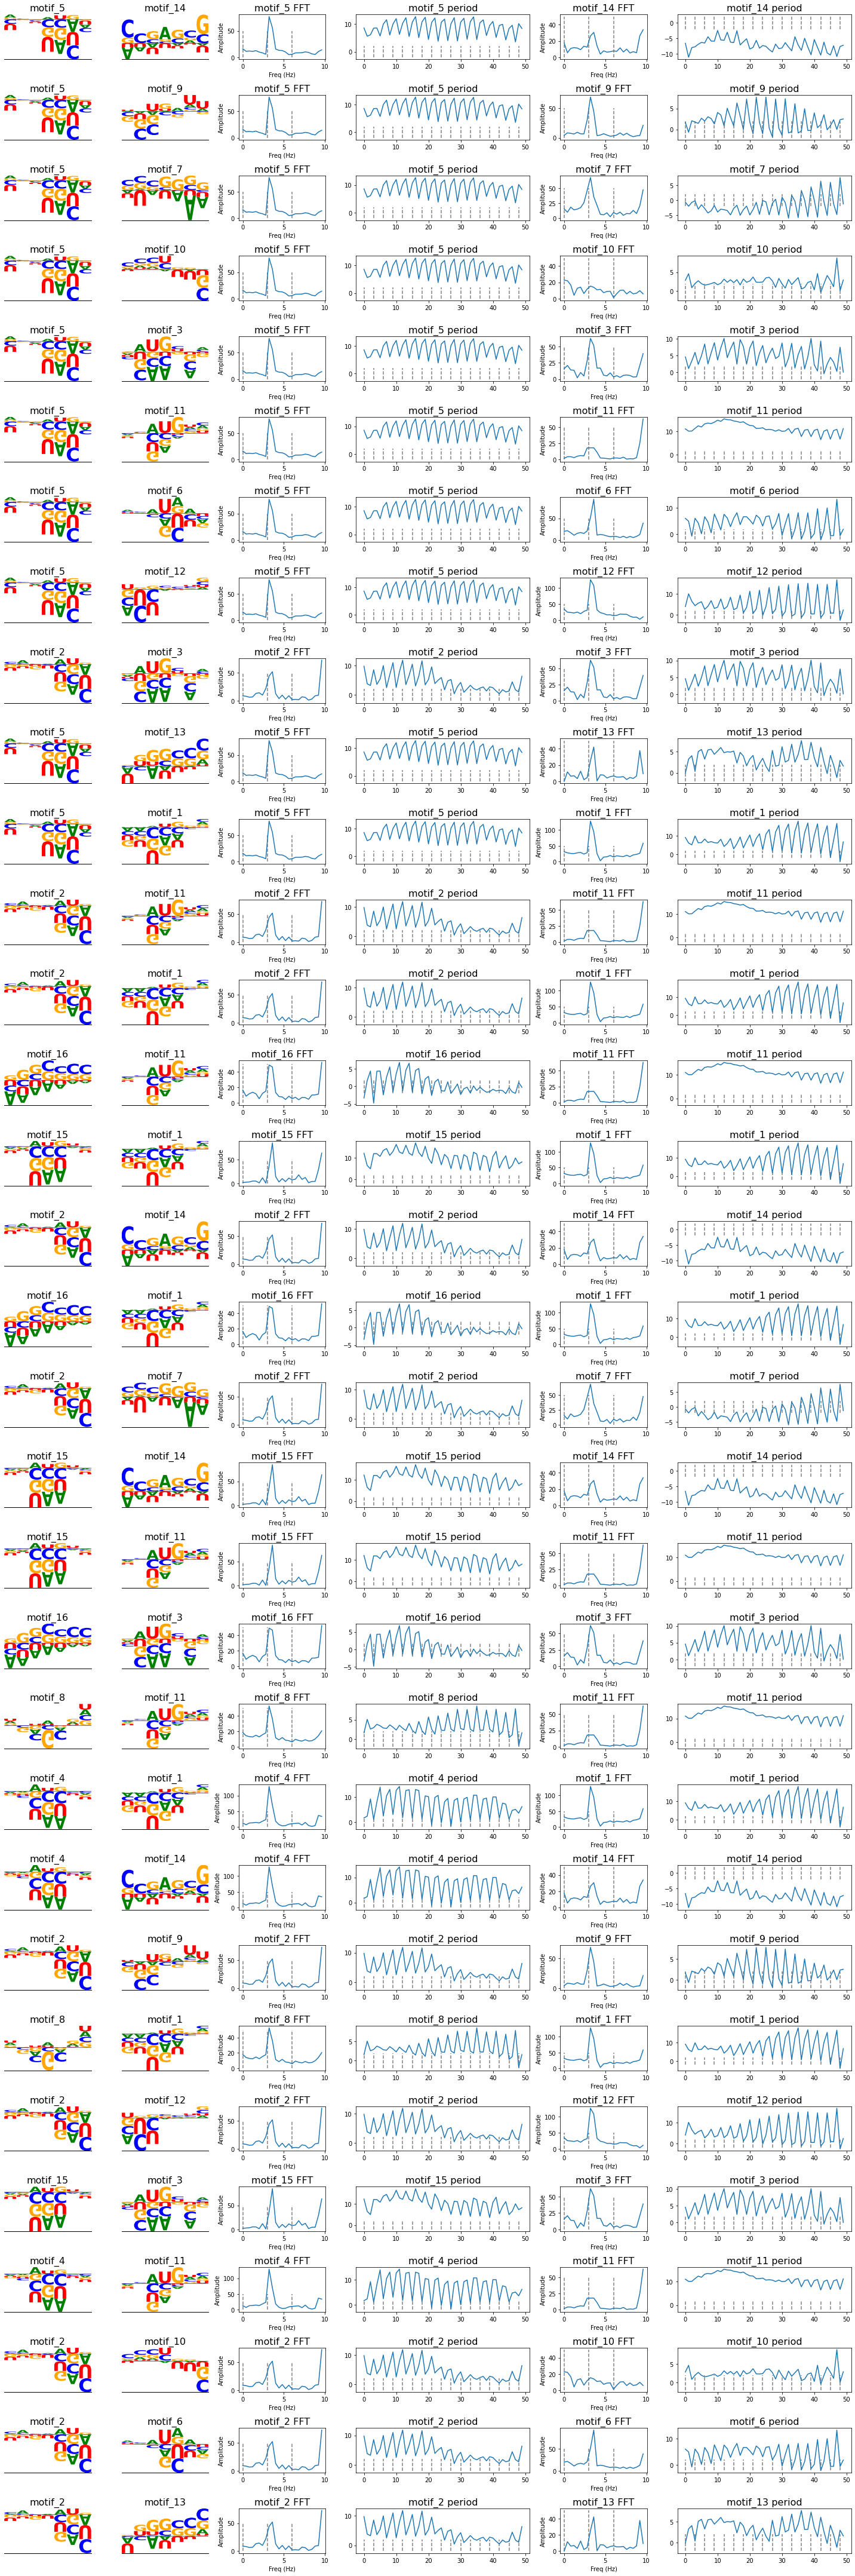

In [8]:
fig, axes = plt.subplots(nrows=32, ncols=6, figsize=(20,60), gridspec_kw={'width_ratios': [0.3, 0.3, 0.3, 0.6, 0.3, 0.6]})

sr = 10

with torch.no_grad():
    for i in range(32):
        ax = axes[i][0]
        nn_df = pd.DataFrame(kernel[idx1[i]].transpose(), columns=list('ACGU'))
        ax.set_title('motif_%d' % (idx1[i]+1), fontdict={"size": 16})
        nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
        nn_logo.style_spines(visible=False)
        nn_logo.style_spines(spines=['bottom'], visible=True)

        nn_logo.ax.set_xticks([])
        nn_logo.ax.set_yticks([])

        ax = axes[i][1]
        nn_df = pd.DataFrame(kernel[idx2[i]].transpose(), columns=list('ACGU'))
        ax.set_title('motif_%d' % (idx2[i]+1), fontdict={"size": 16})
        nn_logo = logomaker.Logo(nn_df, figsize=(4, 1), center_values=False, ax=ax)
        nn_logo.style_spines(visible=False)
        nn_logo.style_spines(spines=['bottom'], visible=True)

        nn_logo.ax.set_xticks([])
        nn_logo.ax.set_yticks([])   
        
        ax = axes[i][2]       
        X = fft(pos_feature[26:76, idx1[i]])
        N = len(X)/2
        T = N/sr
        n = np.arange(N)
        freq = n/T 
        ax.plot(freq, np.abs(X[int(N):]))
        ax.set_xlabel('Freq (Hz)')
        ax.set_ylabel('Amplitude')

        ax.set_title("motif_%d FFT" % (idx1[i]+1),  fontdict={"size": 16})

        for n in range(0, 9, 3):
            ax.vlines(x=n, ymin=0, ymax=50, colors='grey', linestyles='--')
            
        ax = axes[i][3]
        xx = list(range(50))
        ax.plot(xx, pos_feature[25:75, idx1[i]])
        ax.set_title("motif_%d period" % (idx1[i]+1),  fontdict={"size": 16})

        for n in range(0, 50, 3):
            ax.vlines(x=n, ymin=-2, ymax=2, colors='grey', linestyles='--')
            
            
            
            
        ax = axes[i][4]       
        X = fft(pos_feature[26:76, idx2[i]])
        N = len(X)/2
        T = N/sr
        n = np.arange(N)
        freq = n/T 
        ax.plot(freq, np.abs(X[int(N):]))
        ax.set_xlabel('Freq (Hz)')
        ax.set_ylabel('Amplitude')

        ax.set_title("motif_%d FFT" % (idx2[i]+1),  fontdict={"size": 16})

        for n in range(0, 9, 3):
            ax.vlines(x=n, ymin=0, ymax=50, colors='grey', linestyles='--')
            
        ax = axes[i][5]
        xx = list(range(50))
        ax.plot(xx, pos_feature[25:75, idx2[i]])
        ax.set_title("motif_%d period" % (idx2[i]+1),  fontdict={"size": 16})

        for n in range(0, 50, 3):
            ax.vlines(x=n, ymin=-2, ymax=2, colors='grey', linestyles='--')

plt.tight_layout()

In [18]:
fig.savefig("graph/motif_interaction_period.pdf")

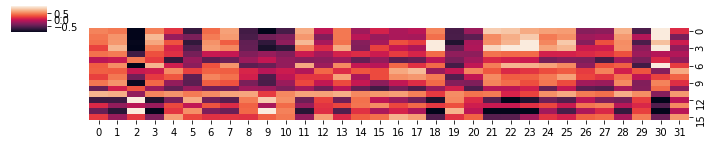

In [8]:
dense = model.mapping1[0].weight

sns.clustermap(dense, 
               col_cluster=False, 
               row_cluster=False,
               robust=True, 
#                annot=True, fmt='.1f',
               dendrogram_ratio=0.12,
               figsize=(10,2), 
#                mask= dense<0.5,
              )

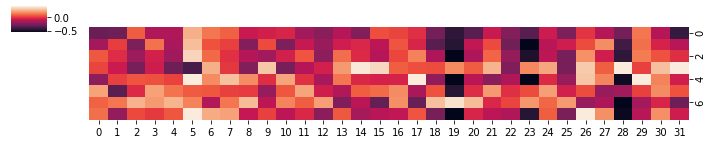

In [8]:
dense = model.mapping2[0].weight.detach().numpy()

sns.clustermap(dense, 
               col_cluster=False, 
               row_cluster=False,
               robust=True, 
               dendrogram_ratio=0.12,
               figsize=(10,2), 
#                mask= dense<0.5,00
              )

In [8]:
cor = np.corrcoef(dense.transpose())
cor.shape

(32, 32)

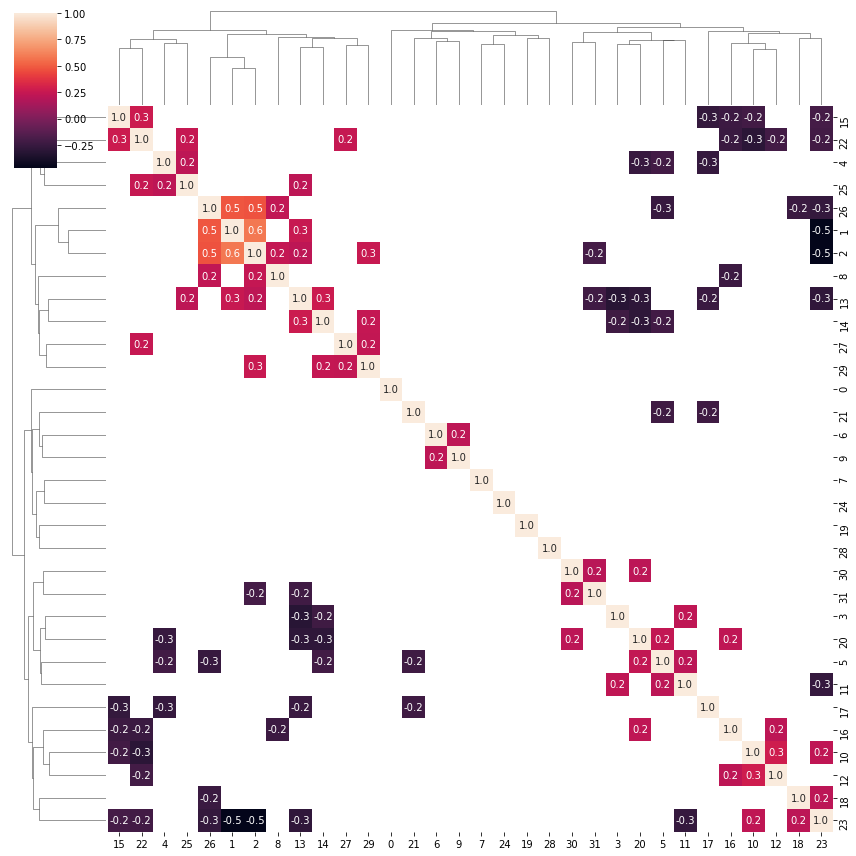

In [10]:
# plt.figure(figsize=(10,4))
sns.clustermap(cor, 
#                row_cluster=False, 
               robust=True, 
               annot=True, fmt='.1f',
               dendrogram_ratio=0.12,
               figsize=(12,12), 
               mask=np.abs(cor)<0.2,
              )